# Traffic Sign Detection
This notebook implements a CNN model for detecting the traffic signs from the [GTSRB Dataset](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) which consists of 43 classes and around 50,000 images (train+test).

In [1]:
%matplotlib inline
import os, glob
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

## Exploratory Data Analysis
We will read three csv files `Meta.csv`, `Train.csv`, `Test.csv` and explore each one of them.

In [2]:
data_path = 'data/'
train_path = data_path + 'Train/'
test_path = data_path + 'Test/'
df_meta = pd.read_csv(data_path + 'Meta.csv')
df_train = pd.read_csv(data_path + 'Train.csv')
df_test = pd.read_csv(data_path + 'Test.csv')

### Exploring Meta Dataframe

In [3]:
df_meta.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


There are four columns in df_meta. `Path`, `ClassId`, `ShapeId`, `ColorId`, `SignId`.

In [4]:
print("Min. Class Label: {}".format(df_meta.ClassId.min()))
print("Max Class Label: {}".format(df_meta.ClassId.max()))
print("Total Class Labels: {}".format(len(df_meta.ClassId.unique())))

Min. Class Label: 0
Max Class Label: 42
Total Class Labels: 43


**Let us visualize all 43 class types** using the coloumn `ClassId`

In [5]:
num_classes = len(df_meta.ClassId.unique())
class_dict = {}
class_labels = list(range(num_classes))
# Speed Class 0-9
speed_class = ['Speed Limit ' + item for item in [speed + ' kmph' for speed in ['20', '30', '50', '60', '70', '80']]]\
            + ['End of Speed Limit 80 kmph']
speed_class+= ['Speed Limit ' + item for item in [speed + ' kmph' for speed in ['100', '120']]]
speed_class
# 10, 11 No Passing
no_pass = ['No Passing' + item for item in ['', ' vehicle over 3.5 ton']]
# 12-43
rest = ['Right-of-way at intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Veh > 3.5 tons prohibited',\
            'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'Bumpy road',
            'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing',
            'Bicycles crossing', 'Beware of ice/snow','Wild animals crossing', 'End speed + passing limits', 'Turn right ahead',
            'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left',
            'Roundabout mandatory', 'End of no passing', 'End no passing vehicle > 3.5 tons']
class_values = speed_class + no_pass + rest
class_dict = {keys:values for keys,values in zip(class_labels, class_values)}

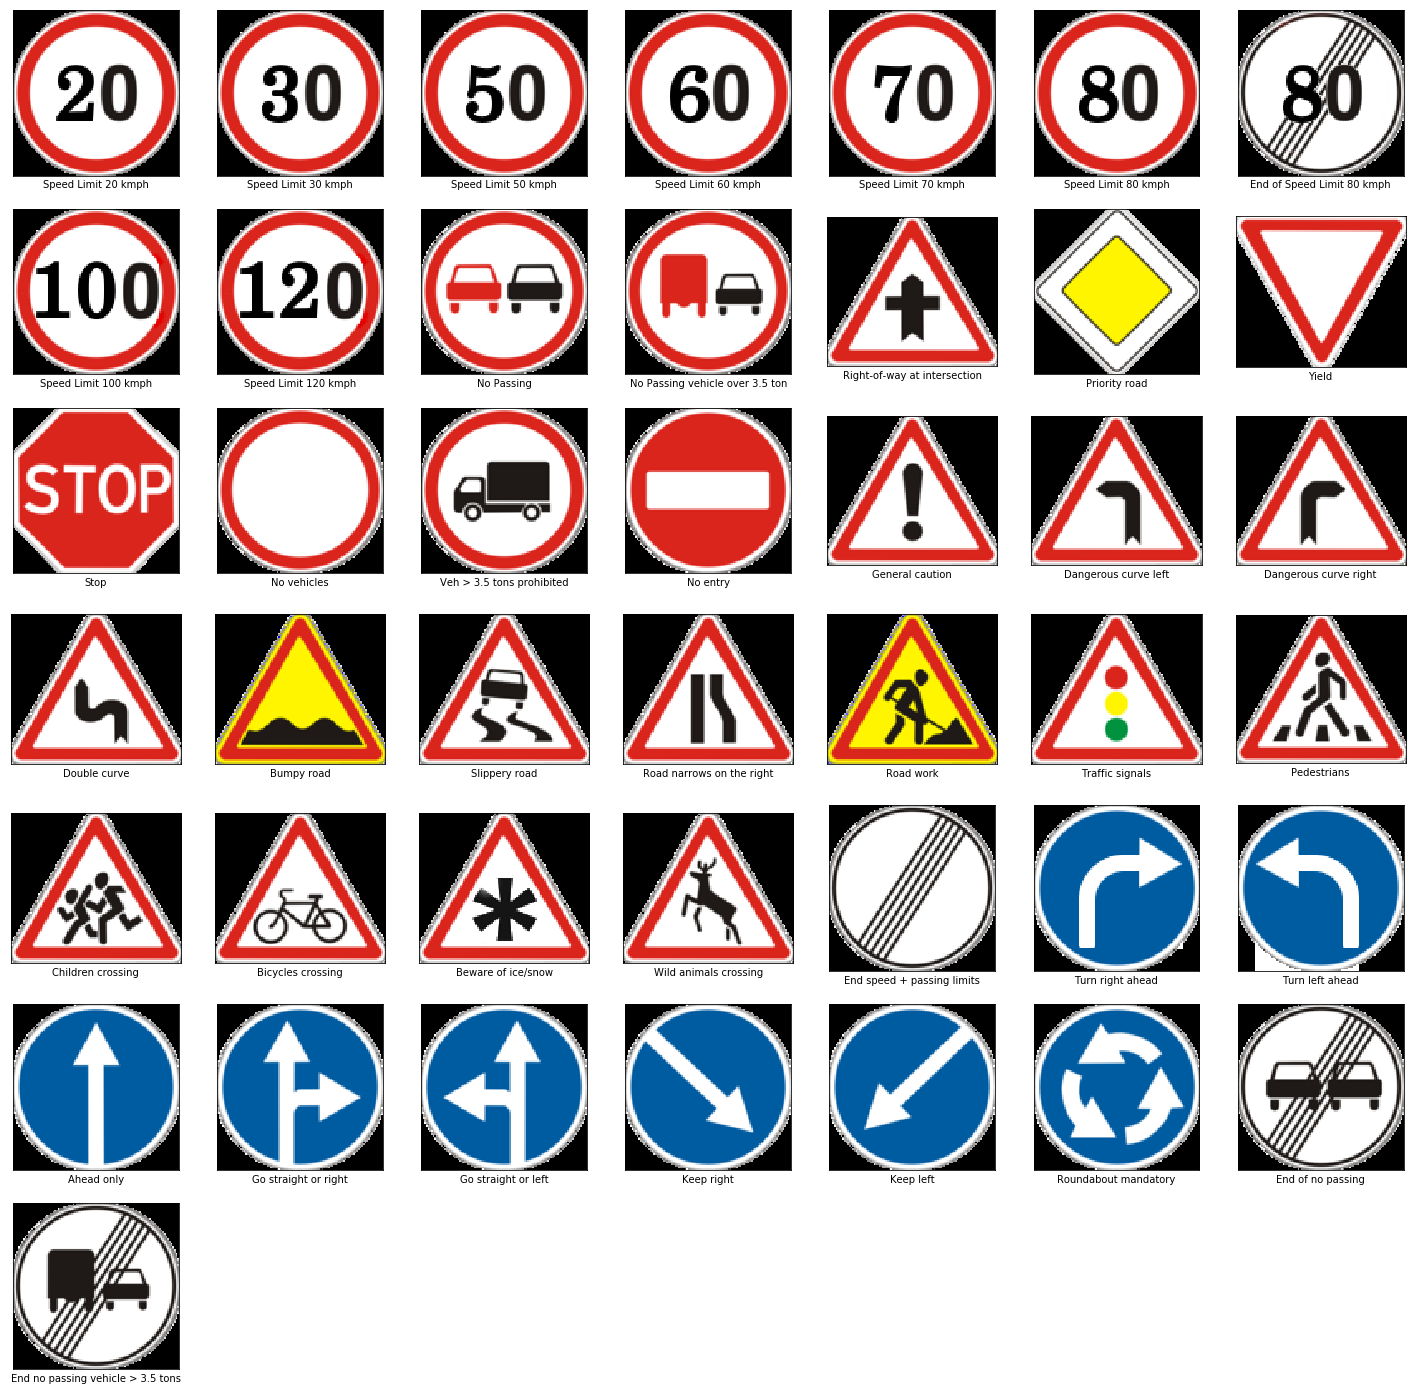

In [6]:
sortFunction = lambda x: int(os.path.basename(x)[:-4])
plt.figure(figsize = (25, 25))
for i, imagename in enumerate(sorted(glob.glob(data_path + 'Meta/' + '*.*'), key = sortFunction)):
    plt.subplot(7, 7, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_dict[i])
    image = cv2.imread(imagename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

**Let us visualize the shapes and colors of the sign** using the columns `ShapeId` and `ColorId`

In [7]:
shape_dict = {0: 'Triangle', 1: 'Circle', 2: 'Diamond', 3: 'Hexagon', 4: 'Inverse Triangle'}
df_meta.ShapeId.value_counts()

1    25
0    15
4     1
3     1
2     1
Name: ShapeId, dtype: int64

In [8]:
def visualize_shape(shape = 0):
    """
    Plots random samples of a particular shape from shape_dict
    """
    filenames = df_meta[df_meta.ShapeId==shape].sample(10).Path
    plt.figure(figsize = (25, 25))
    for i, filename in enumerate(data_path + filenames):
        image = cv2.imread(filename)
        plt.subplot(11, 4, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

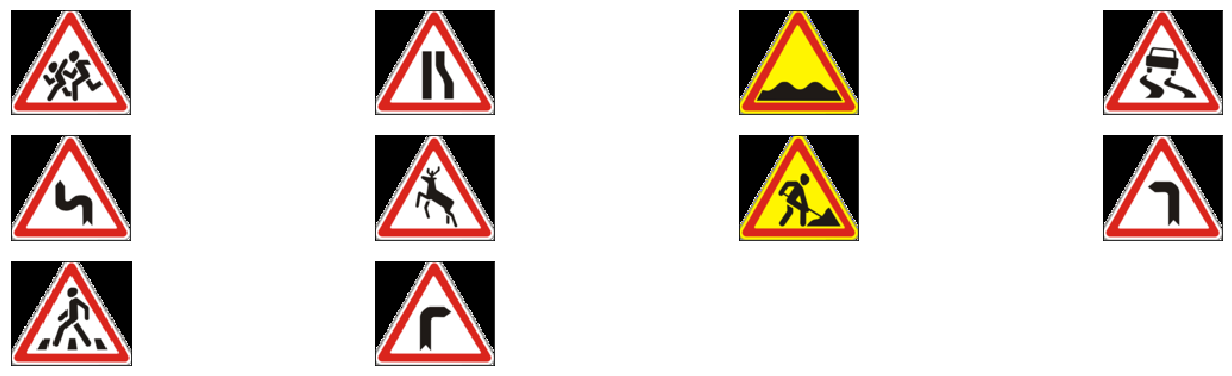

In [9]:
# Visualize Triangular signs, ShapeId=0
visualize_shape(0)

In [10]:
color_dict = {0:'Red', 1:'Blue', 2:'Yellow', 3:'White'}
df_meta.ColorId.value_counts()

0    30
1     8
3     4
2     1
Name: ColorId, dtype: int64

In [11]:
def visualize_color(color = 0):
    """
    Plots random samples of a particular color from color_dict
    """
    filenames = df_meta[df_meta.ColorId==color].sample(5).Path
    plt.figure(figsize = (20, 20))
    for i, filename in enumerate(data_path + filenames):
        image = cv2.imread(filename)
        plt.subplot(1, 6, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

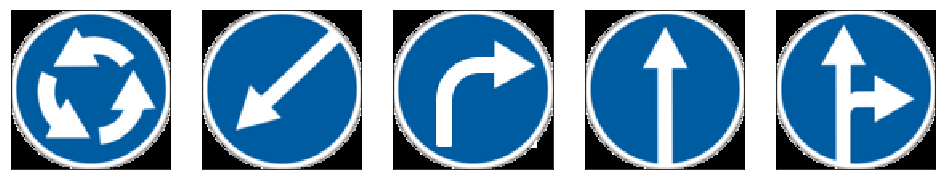

In [12]:
# Visualize Blue Colored Traffic Signs, color = 1
visualize_color(color = 1)

### Exploring Train Dataframe
1. Check the shape of the train dataframe
2. Check the description of all features
3. Create a dictionary `train_dict` with labels as keys and value_counts as values
4. Plot the Class Distribution of Training data
5. Check if the folder directory information is consistent and create the same dictionary `train_sample_dict`

In [13]:
df_train.shape

(39209, 8)

In [14]:
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [15]:
df_train.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [16]:
df_train.ClassId.value_counts()

2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
8     1410
3     1410
11    1320
18    1200
35    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
30     450
34     420
6      420
16     420
22     390
36     390
40     360
20     360
21     330
39     300
24     270
29     270
32     240
42     240
41     240
27     240
37     210
19     210
0      210
Name: ClassId, dtype: int64

In [17]:
# Create a dictionary which consists of the labels as keys and the number of samples as values
train_dict = {}
train_dict = {keys:values for keys,values in zip(df_train.ClassId.value_counts().index, df_train.ClassId.value_counts().tolist())}

Text(0.5, 1.0, 'Class Distribution for Training data')

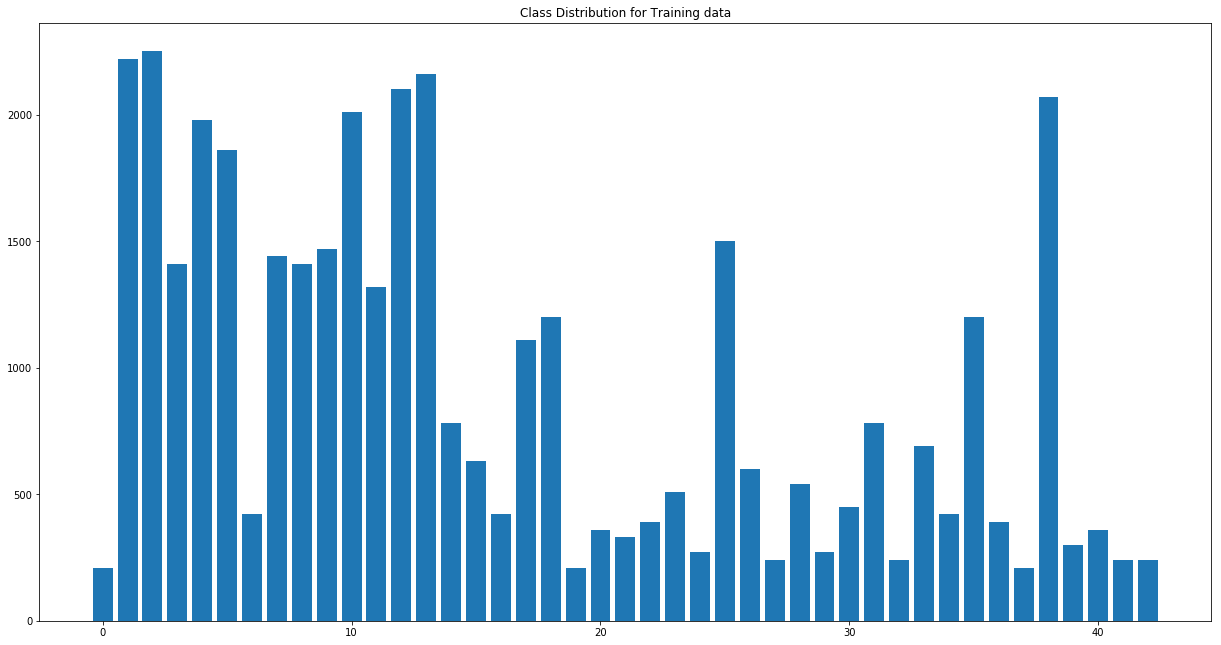

In [18]:
plt.figure(figsize = (21 ,11))
plt.bar(train_dict.keys(), train_dict.values())
plt.title('Class Distribution for Training data')

In [19]:
# Check the dataframe information with folder directory
train_folders = os.listdir(train_path)
# Create a dict with keys as label names and the number of images present inside each label folder as values
sample_dict = {}
for folders in train_folders:
    images = os.listdir(train_path + folders)
    sample_dict[folders] = len(images)
train_sample_dict = {int(k):v for k,v in zip(sample_dict.keys(), sample_dict.values())}
train_dict==train_sample_dict

True

### Test Dataframe
1. Check the shape of the test dataframe
2. Check the description of all features
3. Create a dictionary `test_dict` with labels as keys and value_counts as values
4. Plot the Class Distribution of Test data

In [20]:
df_test.shape

(12630, 8)

In [21]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [22]:
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [23]:
df_test.ClassId.value_counts()

2     750
1     720
13    720
12    690
38    690
10    660
4     660
5     630
25    480
9     480
3     450
8     450
7     450
11    420
35    390
18    390
17    360
14    270
31    270
15    210
33    210
26    180
28    150
23    150
16    150
30    150
6     150
22    120
34    120
36    120
24     90
39     90
42     90
20     90
21     90
29     90
40     90
32     60
27     60
41     60
19     60
37     60
0      60
Name: ClassId, dtype: int64

In [24]:
# Create a test_dict with keys as the labels and values as the value_counts
test_dict = {}
test_dict = {keys:values for keys,values in zip(df_test.ClassId.value_counts().index, df_test.ClassId.value_counts().tolist())}

Text(0.5, 1.0, 'Class Distribution of Test Data')

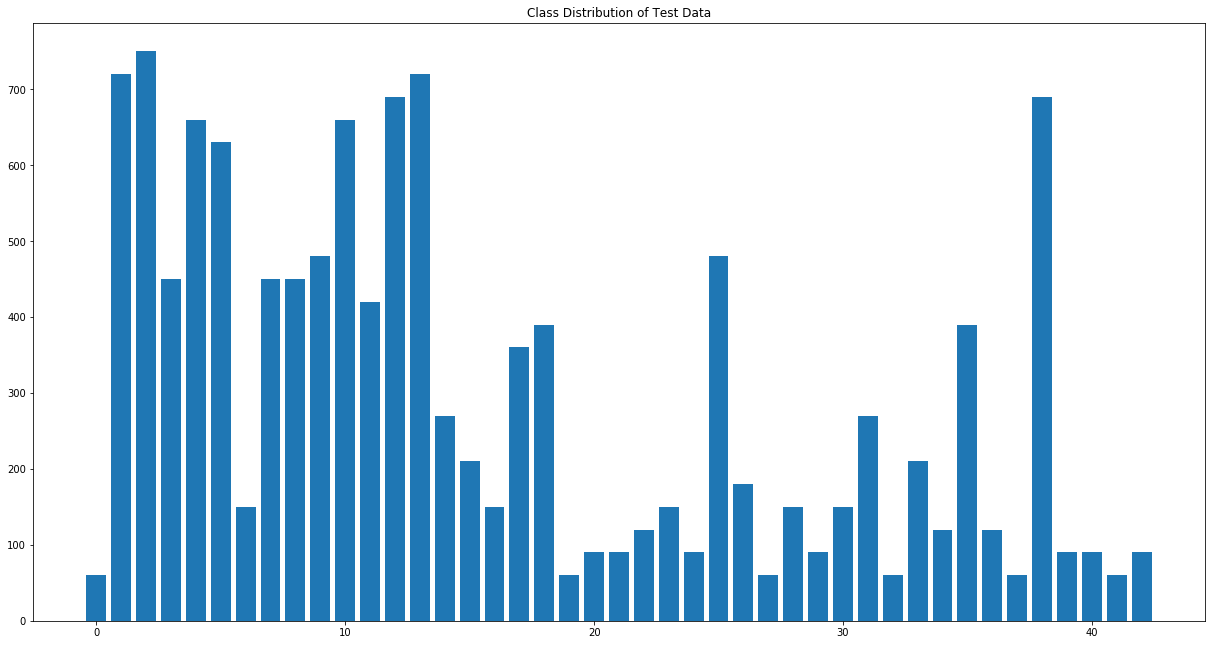

In [25]:
plt.figure(figsize = (21, 11))
plt.bar(test_dict.keys(), test_dict.values())
plt.title("Class Distribution of Test Data")

### Check Data Balance
When we see the individual training and testing class distributions the dataset might seem imbalanced. So we want to check this for each label, by measuring the label-wise train test ratio. This will be important while training the model because when we split the training data into `train` and `validation` we would like to retain the ratio of both sets for each label

In [26]:
df_balance = pd.DataFrame()
df_balance['labels'] = list(range(43))
df_balance['train'] = train_dict.values()
df_balance['test'] = test_dict.values()
df_balance['total'] = df_balance['train'] + df_balance['test']
df_balance['train_ratio'] = df_balance['train']/df_balance['total']
df_balance['test_ratio'] = df_balance['test']/df_balance['total']

**Check train test ratio for the first 10 classes**

In [27]:
df_balance.head(10)

,labels,train,test,total,train_ratio,test_ratio
0,0,210,60,270,0.777778,0.222222
1,1,2220,720,2940,0.755102,0.244898
2,2,2250,750,3000,0.750000,0.250000
3,3,1410,450,1860,0.758065,0.241935
4,4,1980,660,2640,0.750000,0.250000
5,5,1860,630,2490,0.746988,0.253012
6,6,420,150,570,0.736842,0.263158
7,7,1440,450,1890,0.761905,0.238095
8,8,1410,450,1860,0.758065,0.241935
9,9,1470,480,1950,0.753846,0.246154


**Visualize the train test ratio for each label**

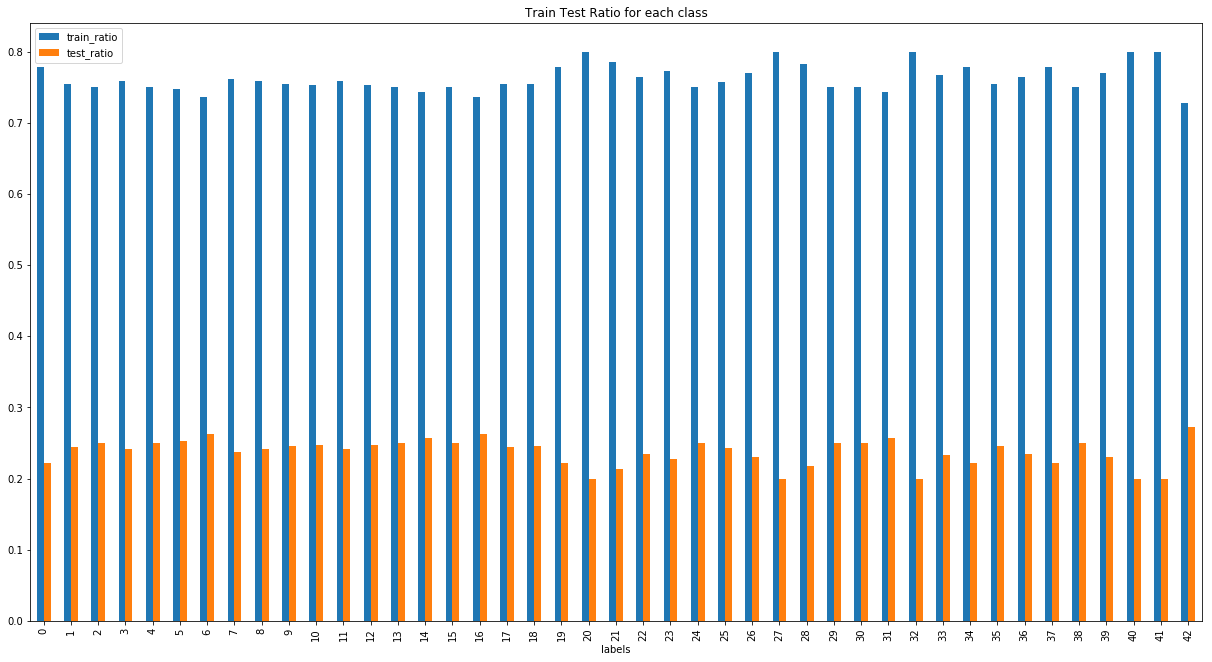

In [28]:
df_balance.plot(x = 'labels', y = ['train_ratio', 'test_ratio'], kind = 'bar', figsize = (21, 11), title = "Train Test Ratio for each class")

**We can see that the data is not that imbalanced when we check labelwise distribution, so data balancing is not required**

### Check Duplicate Entries

In [29]:
df_train.Path.duplicated().unique()

array([False])

In [30]:
df_test.Path.duplicated().unique()

array([False])

**No duplicate entries found in train and test csv files**

## Data Preprocessing
After an extensive EDA, we will prepare our dataset from the `data/Train` and `data/Test`. The `Train` folder consists of 43 folders from `0` to `42`. Each folder consists of images. So we will prepare our training data by iterating over thse folders.

For the `Test` data, the folder consists of only images and the `ground-truth` is given in the dataframe `df_test`, we need to predict the labels for each of these images

Before training the model, we will split the `Train` dataset into `train` and `val` using 80-20 stratified split to retain the ratio of balance. `train` and `test` datasets are already in an approximate split of 75-25. This will lead to an overall split of:

- `Train` 60%
- `Val` 15%
- `Test` 25%

### Training Data
1. Iterate over all folders to get images and labels
2. Store the data in `train_data` and labels in `train_labels`
3. Check whether the length of both arrays is equal to the information provided in `df_train`
4. Split the training data into 2 sets `train` and `val` for training using `stratified train-test split`

In [31]:
train_data = []
train_labels = []
for folders in tqdm.tqdm(train_folders):
    imagefiles = os.listdir(train_path + folders)
    for imagefile in imagefiles:
        path = os.path.join(train_path, folders, imagefile)
        image = Image.open(path)
        image = image.resize((32, 32))
        image = np.array(image)
        train_data.append(image)
        train_labels.append(int(folders))
    

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [08:39<00:00, 12.08s/it]


In [32]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [33]:
# Check the length of both arrays
len(df_train), len(train_data), len(train_labels)

(39209, 39209, 39209)

**The number of images in the train folders are equivalent to the samples given in dataframe.**

In [34]:
print("There are {} images in train dataset".format(len(train_data)))
print("Each image has a dimension of : {}".format(train_data[0].shape))

There are 39209 images in train dataset
Each image has a dimension of : (32, 32, 3)


### Train-Val Split
Use the stratified train-test split which retains the class distribution even after splitting in 80-20 ratio.

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size = 0.2, stratify = train_labels, random_state = 42)
train_unique, y_train_count = np.unique(y_train, return_counts = True)
val_unique, y_val_count = np.unique(y_val, return_counts = True)
y_train, y_val = to_categorical(y_train, num_classes), to_categorical(y_val, num_classes)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(31367, 32, 32, 3) (31367, 43) (7842, 32, 32, 3) (7842, 43)


Text(0.5, 1.0, 'After Splitting into Train and Val')

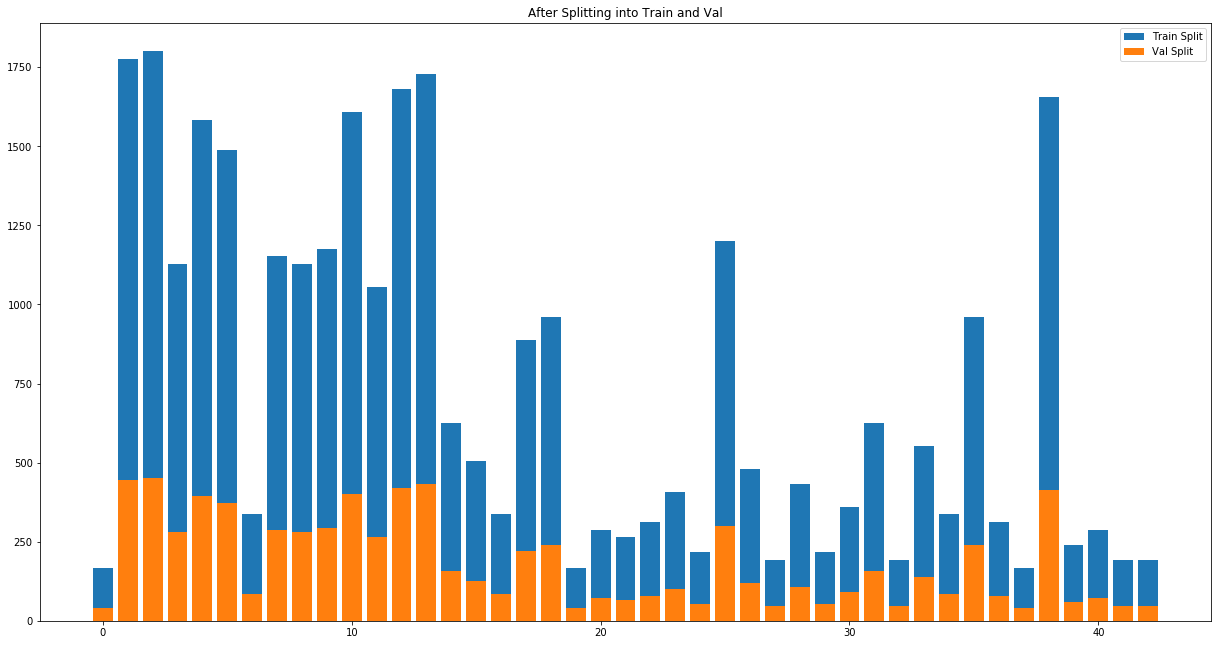

In [36]:
plt.figure(figsize = (21, 11))
plt.bar(train_unique, y_train_count)
plt.bar(val_unique, y_val_count)
plt.legend(['Train Split', 'Val Split'], loc = 'upper right')
plt.title("After Splitting into Train and Val")

### Test Data
1. Iterate over the test directory over all images
2. Store the images in `test_data`
3. Ground truth predictions are given in `df_test`

In [37]:
test_data = []
test_ground_truth = df_test.ClassId.tolist()
test_filenames = (data_path + df_test.Path).tolist()
for test_filename in tqdm.tqdm(test_filenames):
    image_filename = Image.open(test_filename)
    image = image_filename.resize((32, 32))
    image = np.array(image)
    test_data.append(image)

100%|████████████████████████████████████████████████████████████████████████████| 12630/12630 [02:13<00:00, 94.70it/s]


In [38]:
X_test = np.array(test_data)
y_test = np.array(test_ground_truth)

In [39]:
test_unique, y_test_count = np.unique(y_test, return_counts = True)

### Train-Val-Test Split
Visualize the distribution of training, validation and testing data after splitting.

In [40]:
df_balance['val'] = y_val_count
df_balance['val_ratio'] = df_balance['val']/df_balance['total']
df_balance['train_ratio'] = df_balance['train_ratio'] - df_balance['val_ratio']
df_balance.head()

,labels,train,test,total,train_ratio,test_ratio,val,val_ratio
0,0,210,60,270,0.622222,0.222222,42,0.155556
1,1,2220,720,2940,0.604082,0.244898,444,0.151020
2,2,2250,750,3000,0.600000,0.250000,450,0.150000
3,3,1410,450,1860,0.606452,0.241935,282,0.151613
4,4,1980,660,2640,0.600000,0.250000,396,0.150000


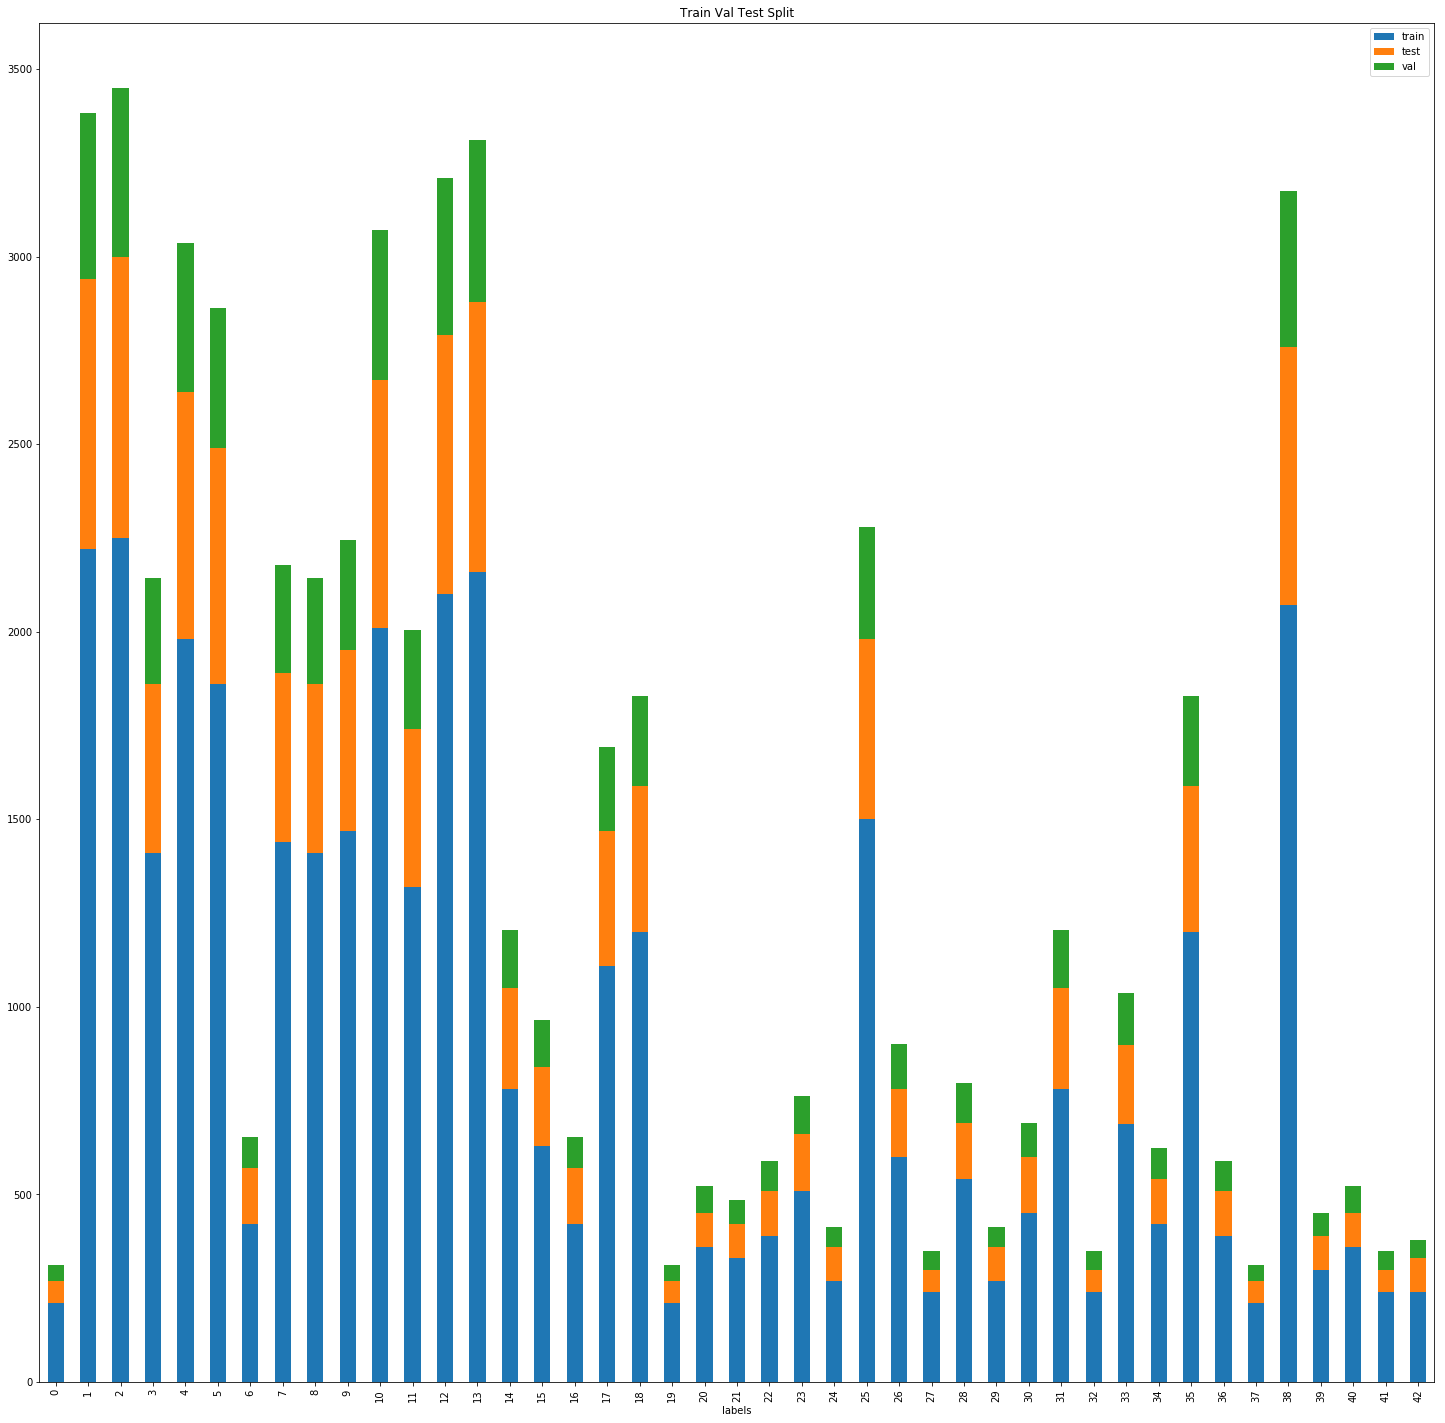

In [41]:
df_balance.plot.bar(x = 'labels', y = ['train', 'test', 'val'], figsize = (25, 25), stacked = True, title = "Train Val Test Split")

## Building Model
We will now build a CNN model for training using Keras.

In [42]:
def get_compiled_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Fit Model
Fit the model using training and validation data

In [43]:
X_train, X_val, X_test = X_train/255., X_val/255., X_test/255.

In [44]:
model = get_compiled_model()

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [46]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), verbose = True)

Train on 31367 samples, validate on 7842 samples
Epoch 1/20
31367/31367 [==============================] - 24s 759us/step - loss: 1.2779 - acc: 0.6313 - val_loss: 0.1863 - val_acc: 0.9517
Epoch 2/20
31367/31367 [==============================] - 13s 401us/step - loss: 0.2477 - acc: 0.9254 - val_loss: 0.1028 - val_acc: 0.9670
Epoch 3/20
31367/31367 [==============================] - 13s 417us/step - loss: 0.1548 - acc: 0.9532 - val_loss: 0.0624 - val_acc: 0.9841
Epoch 4/20
31367/31367 [==============================] - 14s 433us/step - loss: 0.1217 - acc: 0.9624 - val_loss: 0.0423 - val_acc: 0.9888
Epoch 5/20
31367/31367 [==============================] - 12s 387us/step - loss: 0.0951 - acc: 0.9702 - val_loss: 0.0385 - val_acc: 0.9898
Epoch 6/20
31367/31367 [==============================] - 14s 435us/step - loss: 0.0845 - acc: 0.9746 - val_loss: 0.0324 - val_acc: 0.9911
Epoch 7/20
31367/31367 [==============================] - 13s 424us/step - loss: 0.0771 - acc: 0.9763 - val_loss: 0.0

## Visualize Results

### Accuracy Plot

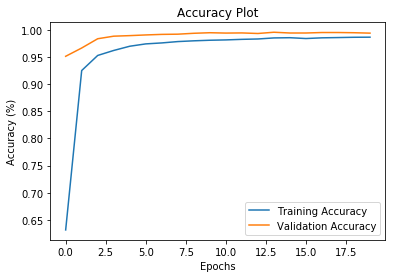

In [47]:
plt.figure()
plt.plot(history.history['acc'], label = "Training Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.title("Accuracy Plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

### Loss Plot

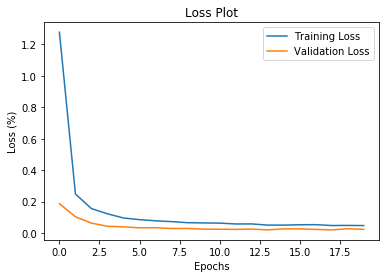

In [48]:
plt.figure()
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Loss (%)")
plt.legend()
plt.show()

## Inference

In [49]:
predictions = model.predict_classes(X_test)

In [51]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
cfm = confusion_matrix(y_test, predictions)

In [52]:
accuracy_score(y_test, predictions)

0.9790973871733967

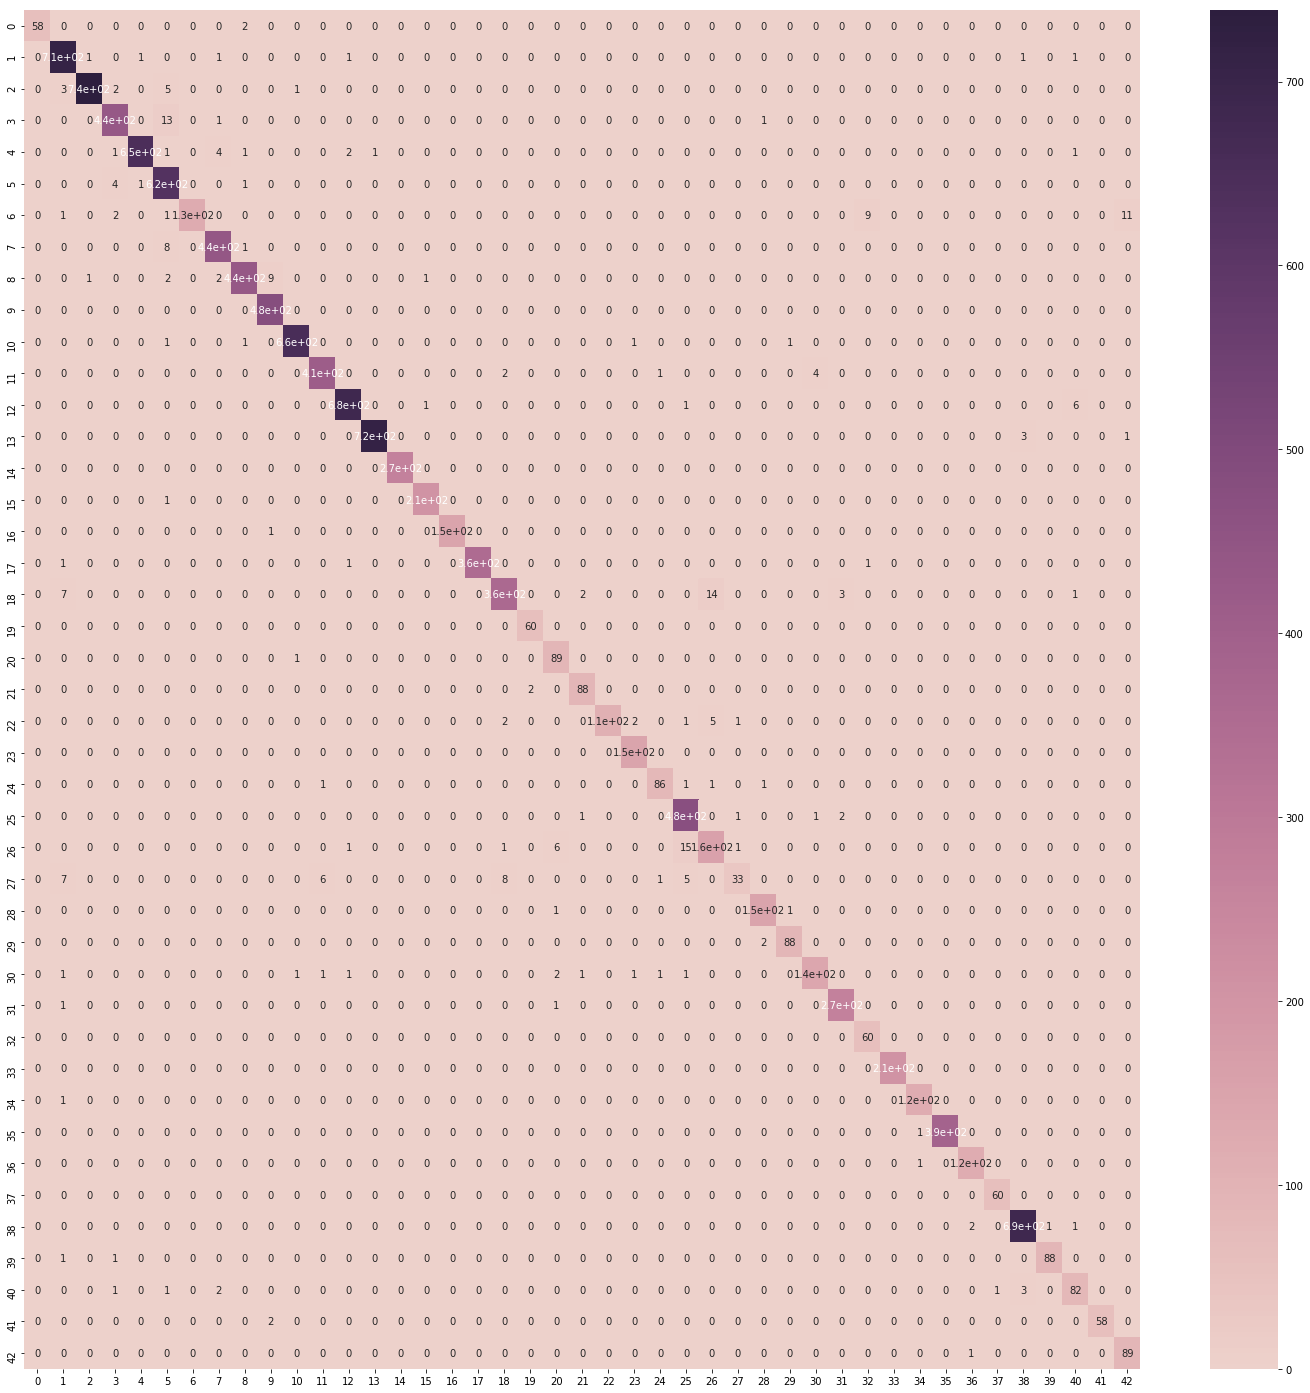

In [53]:
df_cfm = pd.DataFrame(cfm, index = [i for i in range(num_classes)], columns = [i for i in range(num_classes)])
plt.figure(figsize = (25, 25))
sns.heatmap(df_cfm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))

### Visualize Results

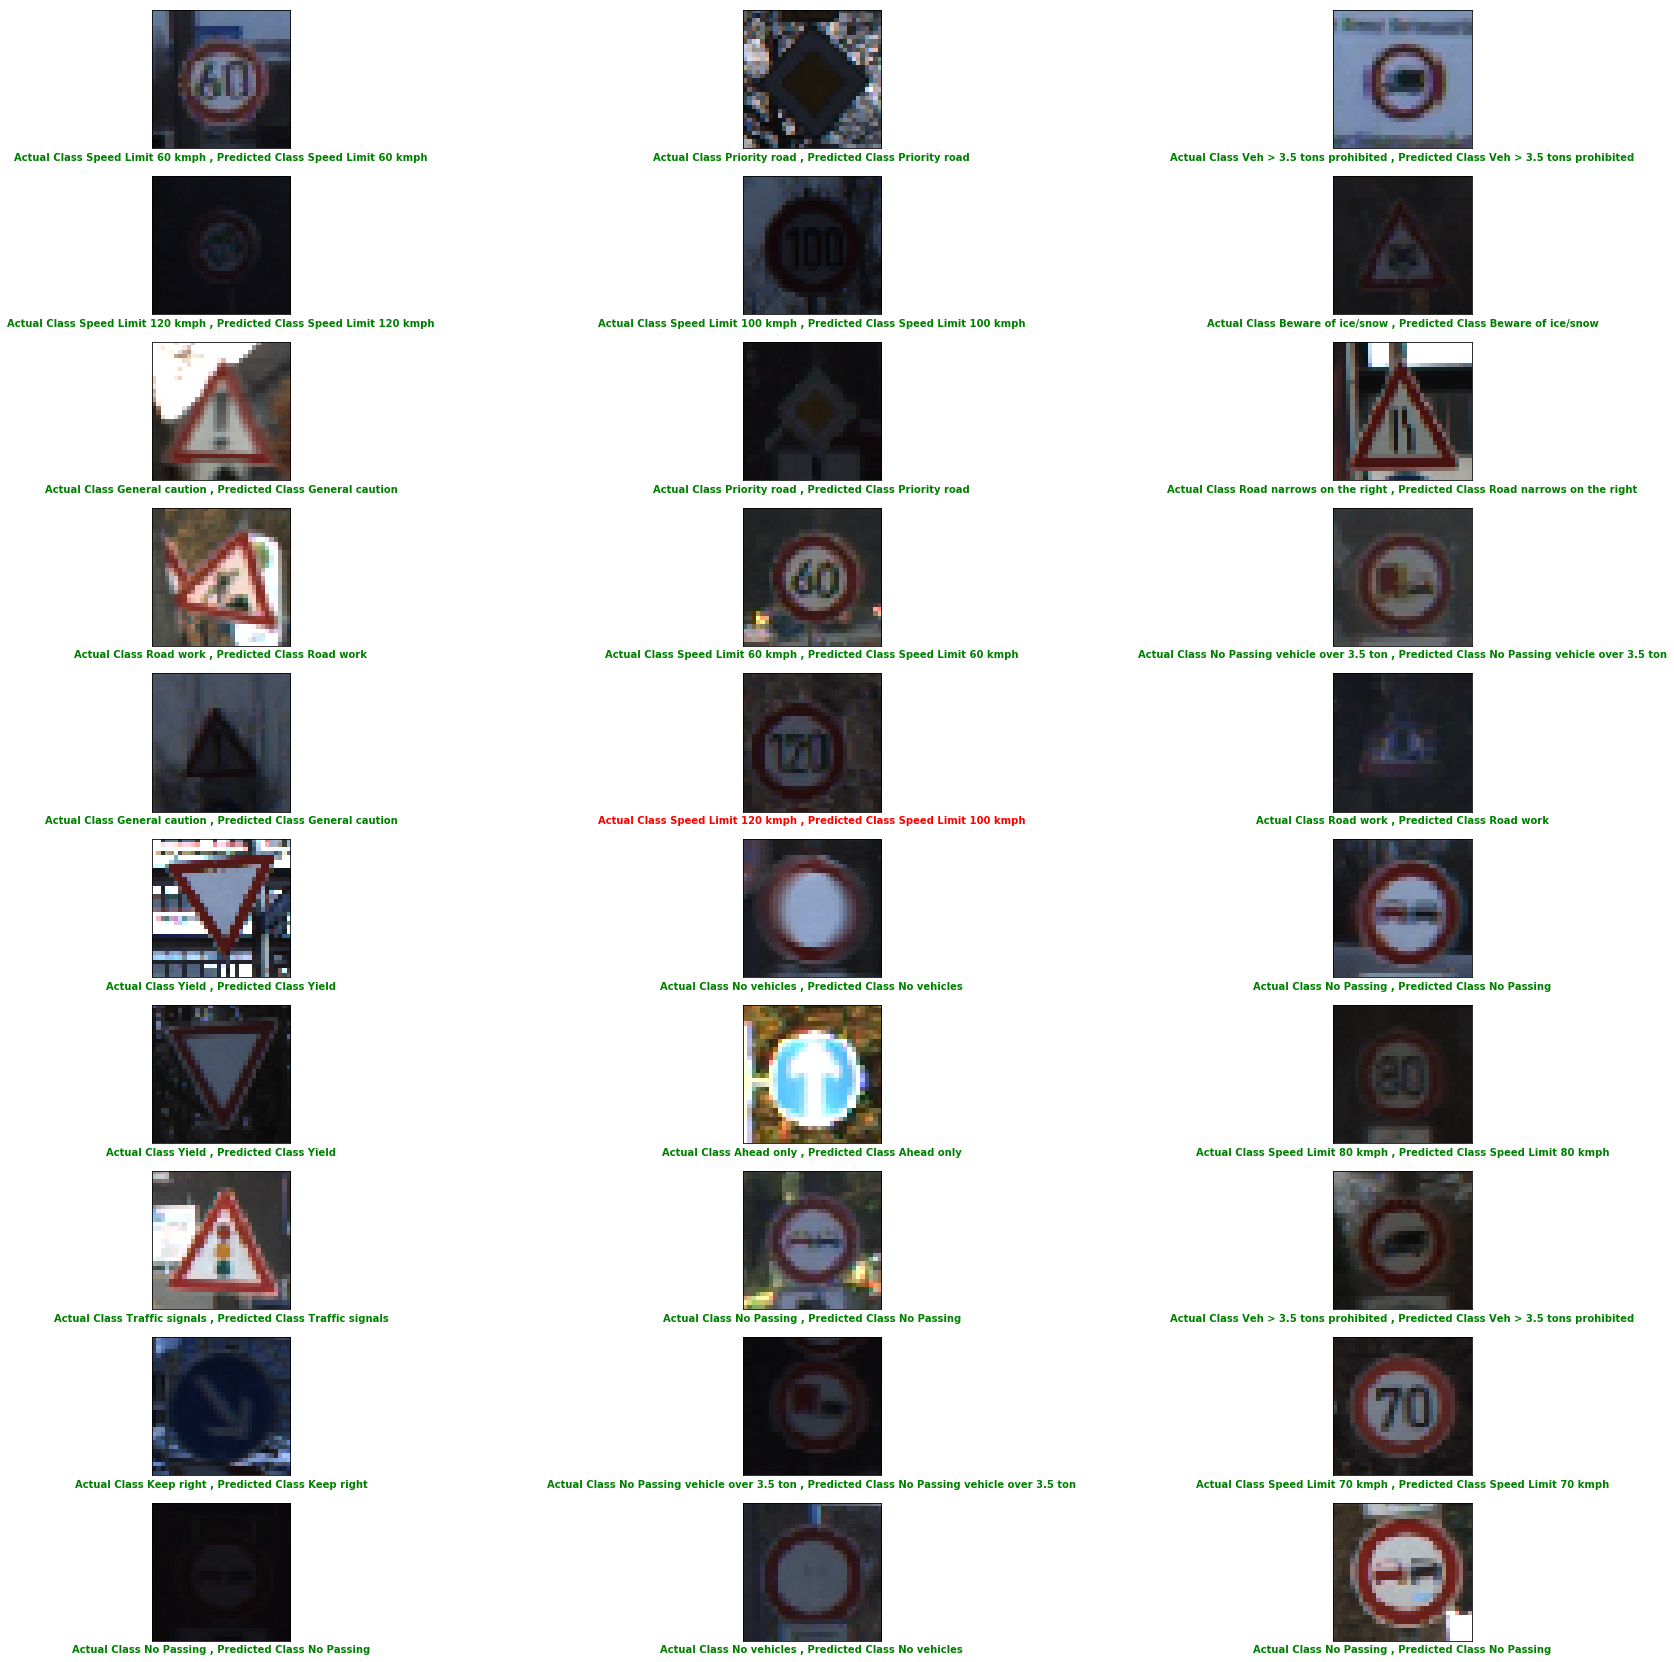

In [54]:
plt.figure(figsize = (30, 30))
start_index = 36
for i in range(30):
    plt.subplot(10, 3, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = predictions[start_index + i]
    ground_truth = y_test[start_index + i]
    col = 'g'
    if prediction != ground_truth:
        col = 'r'
    plt.xlabel('Actual Class {} , Predicted Class {}'.format(class_dict[ground_truth], class_dict[prediction]), color = col, weight = 'bold')
    plt.imshow(X_test[start_index + i])
plt.show()

In [56]:
# Save the model for further implementation
os.mkdir('models')
model.save('models/traffic_sign_detection_gtsrb.h5')

## Future Work
1. Use this model and custom dataset to run inference on video using an object detection framework
2. Implement OCR capability for non English speaking countries
3. Create an interactive dashboard with labelling
4. Deploy this model on Streamlit 